In [2]:
from IPython.display import Image

In [3]:
'''
each observation is a patient represented as a dot (in the plot below), 
where red indicates malignant and blue indicates benign. 
Note: This is a toy example for learning;
'''
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

In [4]:
'''
we will create a linear classifier, 
a fundamental building-block in deep networks.
'''
# Figure 2
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

In [5]:
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C

C.cntk_py.set_fixed_random_seed(1)

Data Generation

In [6]:
input_dim = 2
num_output_classes = 2

In [7]:
np.random.seed(0)

def gen_random_data_sample(sample_size, feature_dim, num_classes):
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)
    
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    
    X = X.astype(np.float32)
    
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    
    return X, Y

In [8]:
mysamplesize = 32
features, labels = gen_random_data_sample(mysamplesize, input_dim, num_output_classes)

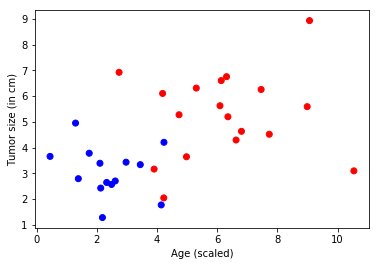

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

colors = ['r' if label == 0 else 'b' for label in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

In [10]:
print(features)

[[  3.44386315   3.33367443]
 [  8.98815823   5.58968353]
 [  6.62613535   4.29180861]
 [  0.44701019   3.65361857]
 [  7.7288723    4.51566982]
 [ 10.53950882   3.09126854]
 [  6.09151697   5.62563229]
 [  9.06555843   8.93871784]
 [  6.30989504   6.75632524]
 [  4.22442865   2.03840709]
 [  5.30417585   6.31269789]
 [  4.23029089   4.2023797 ]
 [  2.61267328   2.69769716]
 [  3.90289402   3.15996408]
 [  1.29372978   4.95077562]
 [  2.49034786   2.56192565]
 [  1.74720466   3.77749038]
 [  1.3861022    2.78725982]
 [  2.10453343   3.38690257]
 [  4.97838974   3.63873553]
 [  2.97181773   3.42833185]
 [  6.13303423   6.60494375]
 [  4.73135567   5.27451754]
 [  2.32753944   2.6404469 ]
 [  2.18685365   1.2737174 ]
 [  6.3548522    5.19643831]
 [  2.73960328   6.92556429]
 [  4.18540335   6.1038909 ]
 [  7.4581809    6.25796604]
 [  4.13940048   1.76517415]
 [  6.80468321   4.63037968]
 [  2.12920284   2.42115045]]


In [11]:
print(labels)

[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]


In [12]:
print(colors)

['b', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r', 'r', 'b', 'b', 'r', 'r', 'r', 'r', 'b', 'r', 'b']


Model Creation

In [13]:
feature = C.input_variable(input_dim, np.float32)

In [14]:
mydict = {}

def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dim, output_dim))
    bias_param = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param
    print(mydict['w'])
    print(mydict['b'])
    print(mydict)
    
    return C.times(input_var, weight_param) + bias_param

In [15]:
output_dim = num_output_classes
z = linear_layer(feature, output_dim)

Parameter('Parameter4', [], [2 x 2])
Parameter('Parameter5', [], [2])
{'w': Parameter('Parameter4', [], [2 x 2]), 'b': Parameter('Parameter5', [], [2])}


In [16]:
label = C.input_variable(num_output_classes, np.float32)
loss = C.cross_entropy_with_softmax(z, label)

In [17]:
eval_error = C.classification_error(z, label)

In [18]:
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

In [19]:
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"
    
    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

Run the trainer

In [20]:
minibatch_size = 25
num_samples_to_train = 20000
num_minibatches_to_train = int(num_samples_to_train / minibatch_size)

In [21]:
from collections import defaultdict

training_progress_output_freq = 50
plotdata = defaultdict(list)

for i in range(0, num_minibatches_to_train):
    features, labels = gen_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss=="NA" or error=="NA" ):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.6931, Error: 0.32
Minibatch: 50, Loss: 1.9350, Error: 0.36
Minibatch: 100, Loss: 1.0764, Error: 0.32
Minibatch: 150, Loss: 0.4856, Error: 0.20
Minibatch: 200, Loss: 0.1319, Error: 0.08
Minibatch: 250, Loss: 0.1330, Error: 0.08
Minibatch: 300, Loss: 0.1012, Error: 0.04
Minibatch: 350, Loss: 0.1091, Error: 0.04
Minibatch: 400, Loss: 0.3094, Error: 0.08
Minibatch: 450, Loss: 0.3230, Error: 0.12
Minibatch: 500, Loss: 0.3986, Error: 0.20
Minibatch: 550, Loss: 0.6744, Error: 0.24
Minibatch: 600, Loss: 0.3004, Error: 0.12
Minibatch: 650, Loss: 0.1676, Error: 0.12
Minibatch: 700, Loss: 0.2777, Error: 0.12
Minibatch: 750, Loss: 0.2311, Error: 0.04


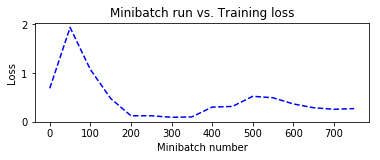

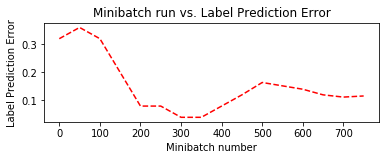

In [22]:
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel("Minibatch number")
plt.ylabel("Loss")
plt.title("Minibatch run vs. Training loss")

plt.show()

plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

In [23]:
test_minibatch_size = 25
features, labels = gen_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature : features, label : labels}) 

0.12

In [24]:
out = C.softmax(z)
result = out.eval({feature : features})

In [25]:
print("Label:", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result[0]])

Label: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [0, 0]


In [26]:
type(result)

numpy.ndarray

In [27]:
print(result)

[[  1.74632873e-02   9.82536733e-01]
 [  9.99639332e-01   3.60626902e-04]
 [  9.98569727e-01   1.43027236e-03]
 [  9.82795119e-01   1.72047615e-02]
 [  9.96637464e-01   3.36252106e-03]
 [  9.74532723e-01   2.54671182e-02]
 [  9.99031365e-01   9.68630076e-04]
 [  9.08705842e-05   9.99909043e-01]
 [  5.11139119e-03   9.94888544e-01]
 [  9.99889970e-01   1.09839588e-04]
 [  3.76815677e-01   6.23184264e-01]
 [  8.43901398e-06   9.99991417e-01]
 [  2.61259731e-02   9.73873913e-01]
 [  9.99786556e-01   2.13358711e-04]
 [  1.27505986e-02   9.87249315e-01]
 [  9.98574436e-01   1.42544729e-03]
 [  4.37100790e-03   9.95628893e-01]
 [  3.49979469e-04   9.99649882e-01]
 [  9.85665321e-01   1.43346060e-02]
 [  9.98898387e-01   1.10162946e-03]
 [  3.59788015e-02   9.64021146e-01]
 [  9.98874426e-01   1.12546189e-03]
 [  9.85284805e-01   1.47151332e-02]
 [  9.61897612e-01   3.81023325e-02]
 [  1.72944993e-01   8.27055037e-01]]


In [28]:
print(labels)

[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]


In [29]:
print("Label    :", [np.argmax(label) for label in labels])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


[ 8.00007153 -8.00006485]


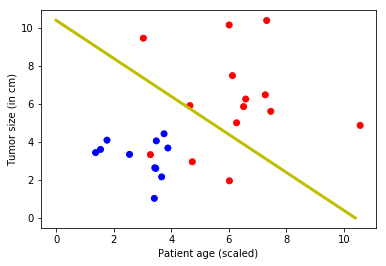

In [30]:
# Model parameters
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# Plot the data 
import matplotlib.pyplot as plt

# let 0 represent malignant/red, and 1 represent benign/blue
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'y', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

In [31]:
print("Label:", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result[6]])

Label: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [0, 0]
